# Implicit representation for mesh reconstruction with Point Clouds

In this lab work we will reconstruct shapes from point sets with and without their normal information.
Each network/method will output the distance or signed distance and one can extract the surface with Marching
cubes, following these steps :
- Use the trained network to compute the values of the signed distance on a grid
- Extract the 0 levelset (marching_cubes method of the mcubes library)
- Save/visualize the mesh (export_obj method of the mcubes library)

In [1]:
!uv pip install potpourri3d
!uv pip install git+https://github.com/skoch9/meshplot.git
!uv pip install pythreejs
!uv pip install pymcubes

Using Python 3.10.14 environment at /home/louis/dev/python/.venv
Audited 1 package in 2ms
Using Python 3.10.14 environment at /home/louis/dev/python/.venv
Resolved 1 package in 578ms                                          
Audited 1 package in 0.06ms
Using Python 3.10.14 environment at /home/louis/dev/python/.venv
Audited 1 package in 2ms
Using Python 3.10.14 environment at /home/louis/dev/python/.venv
Audited 1 package in 2ms


In [2]:
!wget https://www.lix.polytechnique.fr/~pierson/cours/tp_sdf_material.zip

--2024-11-06 23:22:52--  https://www.lix.polytechnique.fr/~pierson/cours/tp_sdf_material.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.lix.polytechnique.fr (www.lix.polytechnique.fr)... 193.55.176.29
Connecting to www.lix.polytechnique.fr (www.lix.polytechnique.fr)|193.55.176.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11946957 (11M) [application/zip]
Saving to: ‘tp_sdf_material.zip.1’

tp_sdf_material.zip 100%[===================>]  11.39M  25.9MB/s    in 0.4s    

2024-11-06 23:22:52 (25.9 MB/s) - ‘tp_sdf_material.zip.1’ saved [11946957/11946957]



In [3]:
!unzip -o tp_sdf_material.zip
!ls

Archive:  tp_sdf_material.zip
  inflating: img/TD5_sdf.png         
  inflating: mesh_utils/.DS_Store    
  inflating: mesh_utils/__init__.py  
  inflating: mesh_utils/mesh.py      
  inflating: mesh_utils/geometry.py  
  inflating: mesh_utils/laplacian.py  
  inflating: mesh_utils/file_utils.py  
  inflating: plot_utils/.DS_Store    
  inflating: plot_utils/__init__.py  
  inflating: plot_utils/utils.py     
  inflating: plot_utils/plot.py      
  inflating: plot_utils/.ipynb_checkpoints/__init__-checkpoint.py  
  inflating: plot_utils/.ipynb_checkpoints/plot-checkpoint.py  
  inflating: armadillo_sub.xyz       
armadillo_sub.xyz  mesh_utils  result_hoppe.obj  tp_sdf_material.zip
img		   plot_utils  TD_5.ipynb	 tp_sdf_material.zip.1


In [1]:
# from google.colab import output
# output.enable_custom_widget_manager()
%matplotlib widget
import numpy as np
import mcubes
import plot_utils as plu
from mesh_utils.mesh import TriMesh
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Traditional reconstruction approach
This method is a "historical" method (<a href="https://dl.acm.org/doi/abs/10.1145/133994.134011">link</a>) for reconstructing a surface from a set of points. It consists in taking an oriented point cloud $(x_i , n_i )$, and estimating for any arbitrary point $x$ in the ambient space a signed distance function as : $u(x) = ± min_i ∥x_i − x∥$

The sign is given by the sign of the scalar product $\langle x - x_i, n_i \rangle$.

The original method starts with unoriented point clouds and devises a clever way to estimate the normal direction and their orientation. Here, for simplicity, we start with oriented points.

In [2]:
def get_pc(path):
    data = np.loadtxt(path)
    point_cloud = data[:,:3]
    normals = data[:,3:]
    ## Load the oriented point set. You can use the function np.loadtxt
    return point_cloud, normals

In [3]:
pc, normals = get_pc("armadillo_sub.xyz")

In [4]:
plu.plot_pc(pc, point_size=2) #You can put cmap = normals to see normals orientation as color

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0216503…

The second step is to compute the sdf based on the set of points. You will first need to build a grid of points (using e.g. np.meshgrid), and then to compute the sdf to the set of points. Don't forget to adapt the limits of the grid to the size of the point cloud! For the distance, use an efficient way to compute the distance (look at solutions of previous labs to get an idea).

In [17]:
from scipy import spatial

def compute_sdf(point_cloud, normals, points_query):
    tree = spatial.KDTree(point_cloud)
    dists, idx = tree.query(points_query)
    # print(points_query.shape, normals.shape)
    signs = np.sign(np.einsum('ij,ij->i', points_query-point_cloud[idx], normals[idx])) # (n, 3)
    sdf = signs * dists
    return sdf[:,None]

def compute_sdf_grid(point_cloud, normals, grid_size=40):
    ## Compute SDF on a XYZ grid. First generate the grid (it has to enclose the point cloud)
    ## Then compute the sdf
    #compute the enclosing grid
    offset = 5
    x_coords = np.linspace(point_cloud[:,0].min()-offset, point_cloud[:,0].max()+offset, grid_size)
    y_coords = np.linspace(point_cloud[:,1].min()-offset, point_cloud[:,1].max()+offset, grid_size)
    z_coords = np.linspace(point_cloud[:,2].min()-offset, point_cloud[:,2].max()+offset, grid_size)
    grid = np.meshgrid(x_coords, y_coords, z_coords) # 3* (40,40,40)

    points_query = np.stack([arr.flatten() for arr in grid], axis=1)
    
    sdf = compute_sdf(point_cloud, normals, points_query).reshape((grid_size, grid_size, grid_size)).transpose(1,0,2)

    return sdf # shape (grid_size, grid_size, grid_size)

In [18]:
sdf = compute_sdf_grid(pc, normals)

(40, 40, 40)


In [19]:
vertices, triangles = mcubes.marching_cubes(sdf,0)
mesh = TriMesh(vertices, triangles)
mcubes.export_obj(vertices, triangles, 'result_hoppe.obj')
plu.plot(mesh)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(19.532195…

You can try different grid sizes, but do not increase too much its size to avoid memory issues

# DeepSDF

This method (see <a href="https://arxiv.org/pdf/1901.05103">link</a>) consists of representing the SDF as a function (x, y, z) -> sdf, parameterized by a neural network.

We first build the network according to the following figure

![title](./img/TD5_sdf.png)

The activations are ReLUs, except for the last one, defined as $\phi(a) = \text{tanh}(a)$.

Moreover, the networks have specific initialization (**except the last one**): the weights of size $n \times n$ are initialized according to the following $\mathcal{N}\left(0, \sqrt{\frac{2}{n}}\right)$ law, and the bias are initalized to 0 (except for the last linear layer). You can access to a Linear layer weight, and bias via layer..weight.data, and layer.bias.data, or use <a href="https://pytorch.org/docs/stable/nn.init.html">nn.init<a> on layer.weight, layer.bias

In [8]:
class SDFNet(nn.Module):
    def __init__(self, ninputchannels, dropout=0.2, gamma=0, sal_init=False, eik=False):
        super(SDFNet, self).__init__()
        ## Prepare the layers
        ## Don't forget to initialize your weights correctly.
        self.dropout = dropout
        
        self.mlp_layers_before_concat = [
            nn.Linear(ninputchannels, 512)
        ] + [
            self.make_linear_block(512,512) for _ in range(2)
        ] + [
            self.make_linear_block(512,509)
        ]

        self.mlp_layers_after_concat = [
            self.make_linear_block(512,512) for _ in range(3)
        ] + [
            nn.Linear(512, 1)
        ]

        self.mlp_before_concat = nn.Sequential(*self.mlp_layers_before_concat)
        self.mlp_after_concat = nn.Sequential(*self.mlp_layers_after_concat)
        ## gamma, sal_init, eik are for later
        self.gamma=gamma
        self.eik = eik
        
    def make_linear_block(self, in_channels, out_channels):
        linear = nn.Linear(in_channels, out_channels)
        if in_channels == out_channels:
            nn.init.normal_(linear.weight.data, mean=0, std=np.sqrt(2/in_channels))
        return nn.Sequential(
            linear,
            nn.ReLU(),
            nn.Dropout(self.dropout)
        )

        #custom weights init

    def forward(self,x):
        ## Logic of the neural network
        ## You can add dropout if you want
        x_transformed = self.mlp_before_concat(x)
        x_transformed = torch.concat([x_transformed, x], dim=1)
        x_out = F.tanh(self.mlp_after_concat(x_transformed))
        return x_out

### Loss function

The loss is computed by sampling random points in the ambient space (set X), computing their ground truth SDF (using part one), and computing the distance between computed and ground truth sdf:

$$
\mathcal{L}(\theta) = \mathbb{E}_{x \sim X} [|\text{clamp}(u_\theta(x), \delta) - \text{clamp}(\text{SDF}_{\text{gt}}(x), \delta)|]
$$

where $\text{clamp}(x, \delta) := \min(\delta, \max(−\delta, x))$ (you can use torch.clamp). To understand the signification of parameter $\delta$, read carefully paragraph 3 of the paper.

In [33]:
# def evaluate_loss(net, pts_gt, sdf_gt, device, lpc, batch_size=2000, delta = 0.1):
#     ## For this function, you need to sample batch_size number of points
#     ## From pts_gt. Evaluate the sdf at those points and compute the loss
#     ## compared to sdf_gt (be careful to select the same points between pts_gt and sdf_gt)

#     # Select points
#     samples_idx = torch.randint(high=pts_gt.shape[0], size=(batch_size,))
#     pts_sample = pts_gt[samples_idx] # (n, 3)

#     sdf_pred = net(pts_sample)

#     # compute and store the losses
#     loss = torch.mean(torch.clamp(sdf_pred, delta) - torch.clamp(sdf_gt[samples_idx],delta))

#     # append all the losses
#     lpc.append(float(loss.item()))

#     return loss

def evaluate_loss(net, pts_gt, sdf_gt, device, lpc, batch_size=2000, delta=0.1):
    # Sample a batch of points from pts_gt
    samples_idx = torch.randint(high=pts_gt.shape[0], size=(batch_size,))
    pts_sample = pts_gt[samples_idx]  # (n, 3)
    
    # Compute SDF predictions for the sampled points
    sdf_pred = net(pts_sample.to(device))
    
    # Compute the clamped SDF values for predicted and ground truth
    sdf_pred_clamped = torch.clamp(sdf_pred, min=-delta, max=delta)
    sdf_gt_clamped = torch.clamp(sdf_gt[samples_idx].to(device), min=-delta, max=delta)
    
    # Compute the loss as the mean absolute difference between clamped SDF predictions and ground truth
    loss = torch.mean(torch.abs(sdf_pred_clamped - sdf_gt_clamped))
    
    # Append the computed loss to lpc
    lpc.append(float(loss.item()))
    
    return loss


### Training the SDF

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_normalized_pointcloud(point_cloud, margin=0.05):
    ## Return the same point cloud, scaled such that 
    ## x,y,z values are between -1+margin and 1-margin
    #compute the enclosing grid
    
    min_vals = point_cloud.min(axis=0, keepdims=True) # (1,3)
    max_vals = point_cloud.max(axis=0, keepdims=True) # (1,3)
    b = 1-margin
    pc_normed = 2*b/(max_vals-min_vals) * point_cloud + b * (1-2*max_vals/(max_vals-min_vals))
    #normalize the points
    print(pc_normed.shape)
    return pc_normed

def compute_gt_sdf(point_cloud, normals, n_points=1000000):
    ## Sample a n_points points in with XYZ coordinates between -1 and 1
    ## Then use compute_sdf to get sdf_gt

    p_norm = get_normalized_pointcloud(point_cloud, margin=0.00001)
     #preparing gt points:   
    
    gtp = np.random.uniform(-1.0, 1.0, size=(n_points, 3))
    sdf_gt = compute_sdf(p_norm, normals, gtp)
    return sdf_gt, gtp

In [35]:
n_points = 100000
sdf_gt, gtp = compute_gt_sdf(pc, normals, n_points)

(208145, 3)


In [36]:
print(device)
print(sdf_gt.shape, gtp.shape) ## Should be same shape
print(np.isclose(gtp.max(), 1, 1e-3), np.isclose(gtp.min(), -1, 1e-3)) ## Should be equal to one

cpu
(100000, 1) (100000, 3)
True True


In [40]:
def training_sdf(sdf_gt, gtp):
    geomnet = SDFNet(3)
    geomnet.to(device)
    gtpoints = torch.from_numpy(gtp).float().to(device)
    gtsdf = torch.from_numpy(sdf_gt).float().to(device)

    lpc = []

    optim = torch.optim.Adam(params = geomnet.parameters(), lr=1e-5)

    nepochs=10000
    pbar = tqdm(total=nepochs,
                desc="Training")

    for epoch in range(nepochs):
        loss = evaluate_loss(geomnet, gtpoints, gtsdf, device, lpc, delta = 0.1, batch_size=2500)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if epoch % 100 == 0:
        #     print(f"Epoch {epoch}/{nepochs} - loss : {loss.item()}")
            pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)
    return lpc, geomnet


In [41]:
loss_, net_sdf = training_sdf(sdf_gt, gtp)
## If the training is slow (hours), change you execution environment to GPU!

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

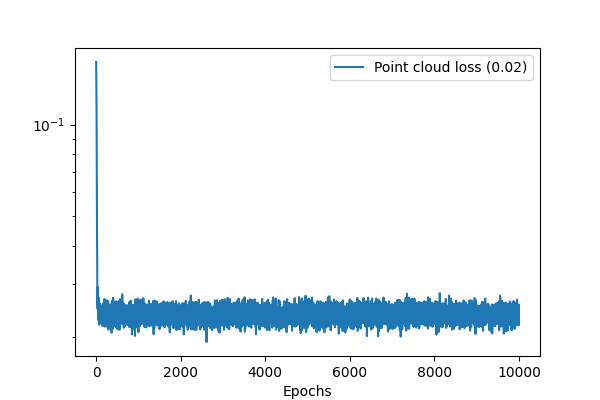

In [42]:
# Check that the network learned something
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(loss_, label = 'Point cloud loss ({:.2f})'.format(loss_[-1]))
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Reconstruct the shape
Code the function compute_deepsdf that compute sdf on a grid using a trained sdf network

In [49]:
def compute_deepsdf(net, grid_size=40):
    net.eval()
    

    x_coords = np.linspace(-1, 1, grid_size)
    y_coords = np.linspace(-1, 1, grid_size)
    z_coords = np.linspace(-1, 1, grid_size)
    grid = np.meshgrid(x_coords, y_coords, z_coords) # 3* (40,40,40)

    v = np.stack([arr.flatten() for arr in grid], axis=1)
    queries = torch.from_numpy(v).float().to(device)
    with torch.no_grad():
        distance = net(queries).detach().cpu().numpy()
    u = np.reshape(distance,(grid_size,grid_size,grid_size))
    print(u.shape)
    return u

In [50]:
u = compute_deepsdf(net_sdf, 40)
vertices, triangles = mcubes.marching_cubes(u,0)
mesh = TriMesh(vertices, triangles)
mcubes.export_obj(vertices, triangles, 'result_deepsdf.obj')
plu.plot(mesh)

(40, 40, 40)


ValueError: zero-size array to reduction operation maximum which has no identity

# Unsigned Distance Function

In this case (paper <a href="https://arxiv.org/pdf/1911.10414">link</a>), the objective is to learn directly on raw point clouds, without pre-processing to predicts normals/orientation of the shape. To reach this objective, the authors notice the following:
- Using the usigned distance function (absolute value of the predicted SDF) is then necessary
- Carefully choosing the points where to predict the distance is crucial
- Weights initialization is to be changed

The modification to SDF is simple : the loss is now computed by sampling points around each data point $x_i$ , following a centered Gaussian distribution of variance $\sigma²$:

$$
\mathcal{L}(\theta) = \sum_i \mathbb{E}_{x \sim \mathcal{N}(x_i, \sigma^2)}[(|u_{\theta}(x)| - |\text{SDF}_{\text{GT}}](x)|)^2)]
$$

where $\sigma$ is a parameter that you can play with, and $\text{SDF}_{\text{GT}}(x)$ is simply $\text{dist}(x_i, x)$.

The last linear layer is now initialized too, with weights following $\mathcal{N}\left(0, 2\sqrt{\pi}\right)$ law and bias initialized to -1. The last layer activation is now $\phi(a) = \text{tanh}(a) + \gamma a$. Gamma parameter now equals to 0.5.

## Neural network
- Modify SDFNet with sal_init, such that when sal_init=True, the last layer is initialized properly
- Take in account gamma parameter in the network logic

## Loss function 
Implement the SAL loss function

In [ ]:
 def evaluate_loss_sal(net, p, sigma, device, losses,batch_size=5000):
    ## Sample batch_size points, and then sample a random point around each point

    #sample points  around each of the samples

    

    # evaluate distances and compute the loss
    # compute and store the losses
    loss = 
    losses.append(loss.item())

    return loss

In [ ]:
def training_sal(point_cloud, loss_function, sigma=0.02):
    geomnet = SDFNet(3, gamma=0.5, sal_init=True)
    geomnet.to(device)

    pc_norm = get_normalized_pointcloud(point_cloud)
    points_torch = torch.from_numpy(pc_norm).float().to(device)

    lpc = []

    optim = torch.optim.Adam(params = geomnet.parameters(), lr=1e-4)

    nepochs=5000
    pbar = tqdm(total=nepochs,
                desc="Training")

    for epoch in range(nepochs):
        loss = loss_function(geomnet, points_torch, sigma, device, lpc, batch_size=5000)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if epoch % 100 == 0:
        #     print(f"Epoch {epoch}/{nepochs} - loss : {loss.item()}")
            pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)


    return lpc, geomnet

In [ ]:
# If you get an error: did you modify SDFNet according to the instructions?
loss_sal, net_sal = training_sal(pc, evaluate_loss_sal, sigma=0.02)

In [ ]:
# Check that the network learned something
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(loss_sal, label = 'Point cloud loss ({:.2f})'.format(loss_[-1]))
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
u = compute_deepsdf(net_sal, 40)
vertices, triangles = mcubes.marching_cubes(u,0)
mesh = TriMesh(vertices, triangles)
plu.plot(mesh)

The produced signed distances using the proposed are too smooth and can't overfit a single shape. Therefore, the authors propose to learn the $L_0$ unsigned distance, by minimizing:

$$
\mathcal{L}(\theta) = \sum_i \mathbb{E}_{x \sim \mathcal{N}(x_i, \sigma^2)}[||u_{\theta}(x)| - 1|] + \mathbb{E}_{x \in \mathcal{X}}[|u_{\theta}(x)|],
$$

i.e. we want the distance to be $1$ outside of the surface, and $0$ on the surface.

Write the function evaluate_loss_sal_l0 below accordingly, and launch a new training to see the effects on the results.

In [ ]:
def evaluate_loss_sal_l0(net, p, sigma, device, losses,batch_size=5000):
    ## Do the sampling and evaluations

    # compute and store the losses
    loss =  

    losses.append(loss.item())

    return loss

In [ ]:
loss_sal_0, net_sal_0 = training_sal(pc, evaluate_loss_sal_l0, sigma=0.02)

In [ ]:
# Check that the network learned something
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(loss_sal_0, label = 'Point cloud loss ({:.2f})'.format(loss_sal_0[-1]))
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
u = compute_deepsdf(net_sal_0, 40)
vertices, triangles = mcubes.marching_cubes(u,0)
mesh = TriMesh(vertices, triangles)
plu.plot(mesh)

You can play with the sigma parameter to improve the results (see the paper to choose it wisely).